In [1]:
%load_ext autoreload
%autoreload 2
from stock_prediction.etl.ticker_data_extractors import train_test_split
from stock_prediction.utils.series import get_normalized_nsteps_ahead_predictions_array
from stock_prediction.modeling.baselines import (
    RollingGeometricAverage,
    NoReturnForecast,
)
from stock_prediction.evaluation.analysis import summary_analysis

In [2]:
df_train, df_test = train_test_split()

## Rolling Geometric Average baseline & Metrics definition

In [3]:
w_size = 20
# We want to use at least half of the training data to fit
# the model on each TCV step so here we define the range on
# which to predict. Note that we also reject the last w_size
# points because we compute our prediction error on the w_size
# days at each time step
i_predict_min = df_train.shape[0] // 2
i_predict_max = df_train.shape[0] - w_size - 1

In [4]:
df_train_cumulative = (1 + df_train).cumprod()
actuals = get_normalized_nsteps_ahead_predictions_array(
    df=df_train_cumulative,
    n_steps_ahead=w_size,
    index_start=i_predict_min,
    index_end=i_predict_max,
)

In [5]:
rolling_geom_avg_model = RollingGeometricAverage(window=w_size)
rolling_geom_avg_model.fit(df_train)

2024-11-05 18:33:27,081 - stock_logger - INFO - This model simply uses a rolling average rule so it is not fitted.


In [6]:
df_train.shape

(1990, 97)

In [7]:
predictions = rolling_geom_avg_model.predict(
    df_train, n_steps_predict=w_size, index_start=i_predict_min, index_end=i_predict_max
)

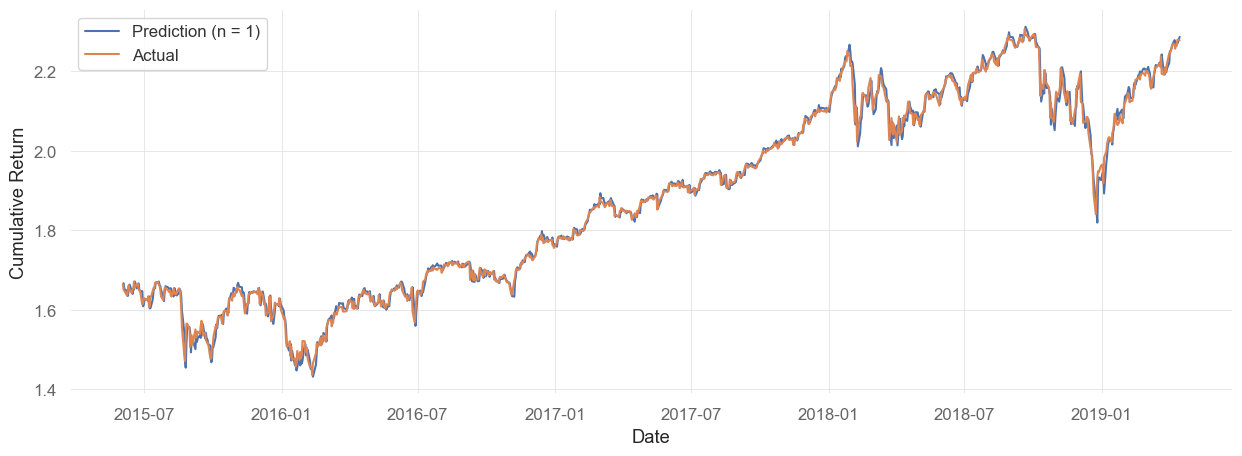

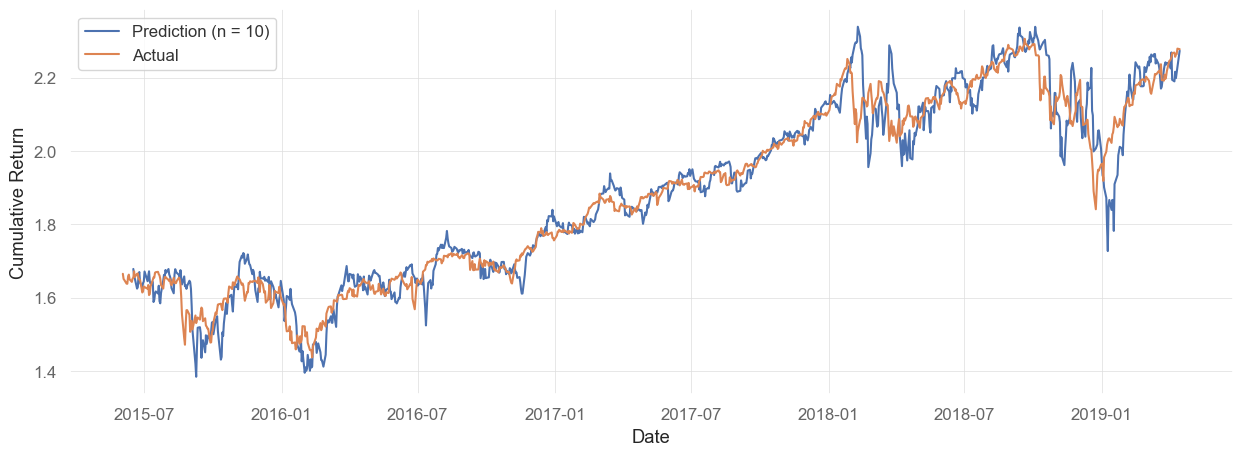

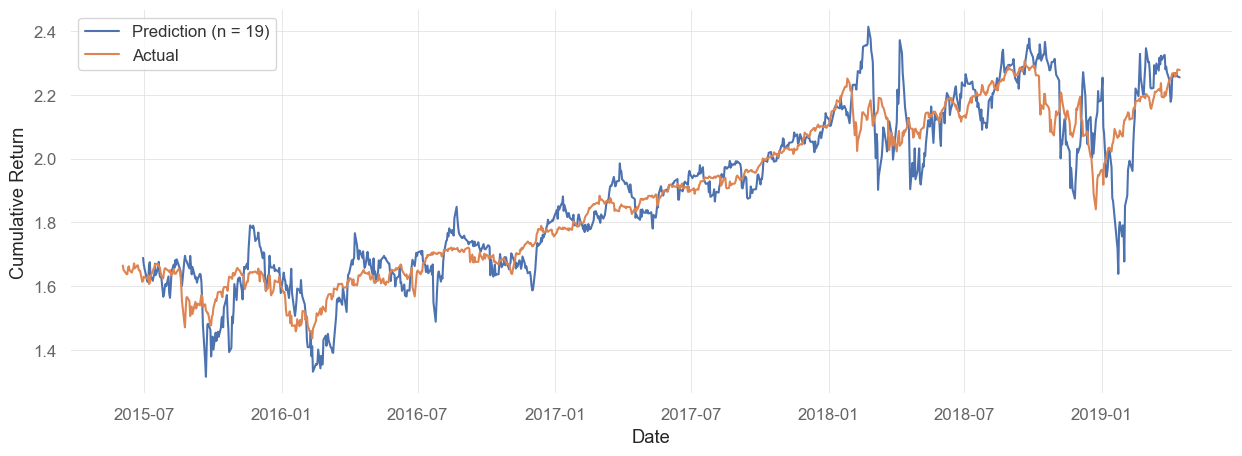

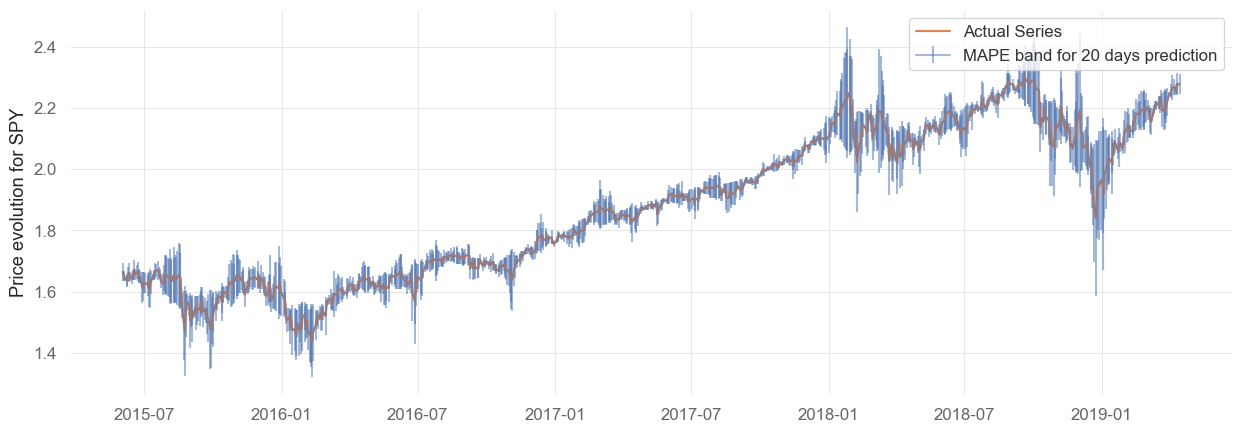

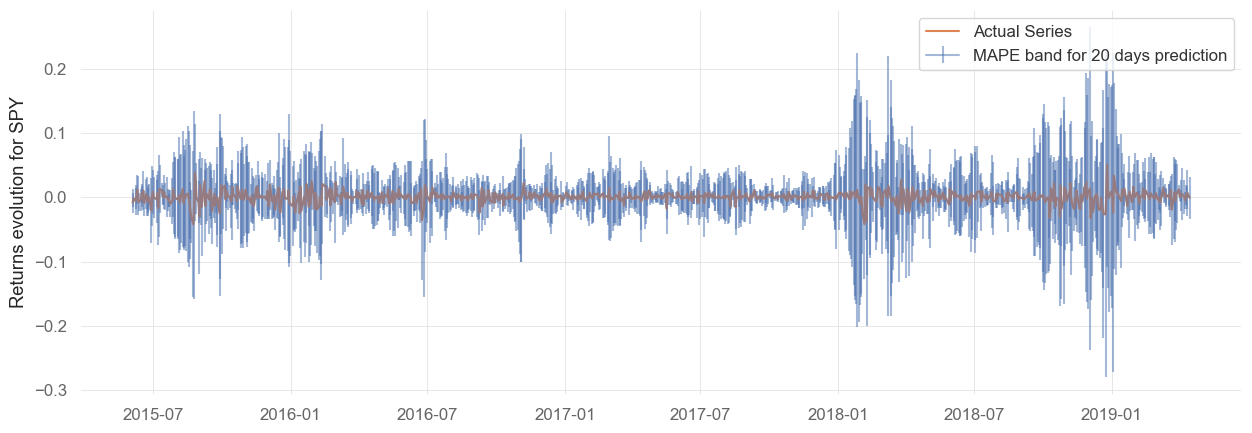

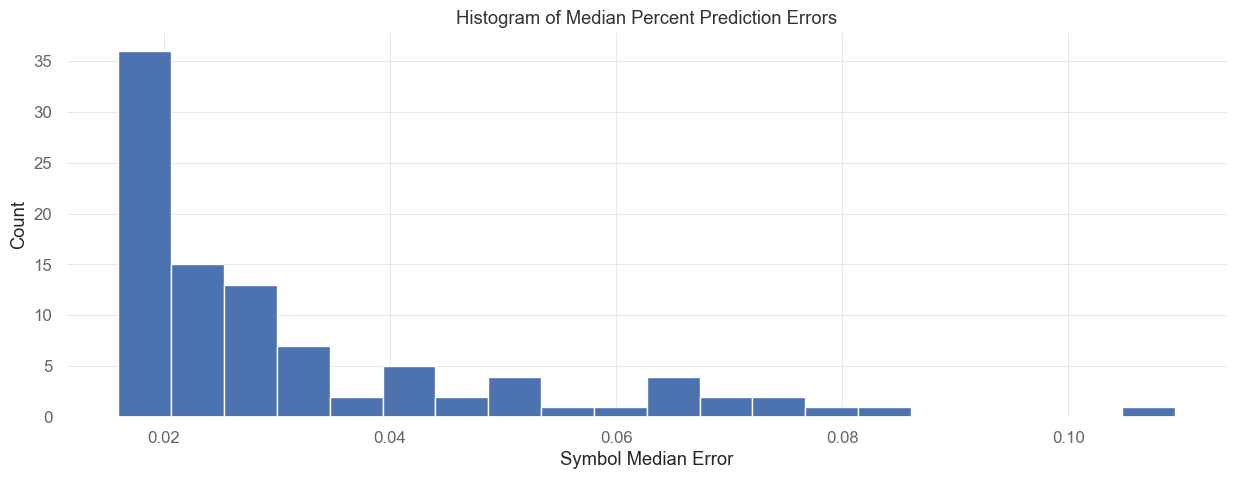

count    97.000000
mean      0.031734
std       0.018921
min       0.015967
25%       0.018009
50%       0.024273
75%       0.035139
max       0.109453
Name: 50%, dtype: float64
Median of Median Errors    0.024273
Mean of Median Errors      0.031734
Mean of Mean Errors        0.040117
dtype: float64


In [8]:
summary_analysis(
    df=df_train,
    n_predict=w_size,
    predictions=predictions,
    actuals=actuals,
    index_start=i_predict_min,
    index_end=i_predict_max,
    symbol="SPY",
)

Our optimization target for TCV will be mean of mean errors. We can see that our simple baseline performs with a 4% mean error. Is this any better than a baseline that just predicts the same value as the last value observed for the price (i.e., no return)?

In [9]:
last_value_model = NoReturnForecast(window=w_size)
last_value_model.fit(df_train)

2024-11-05 18:33:50,422 - stock_logger - INFO - This model simply uses the last observed value so it is not fitted.


In [10]:
predictions_last_value = last_value_model.predict(
    df_train, n_steps_predict=w_size, index_start=i_predict_min, index_end=i_predict_max
)

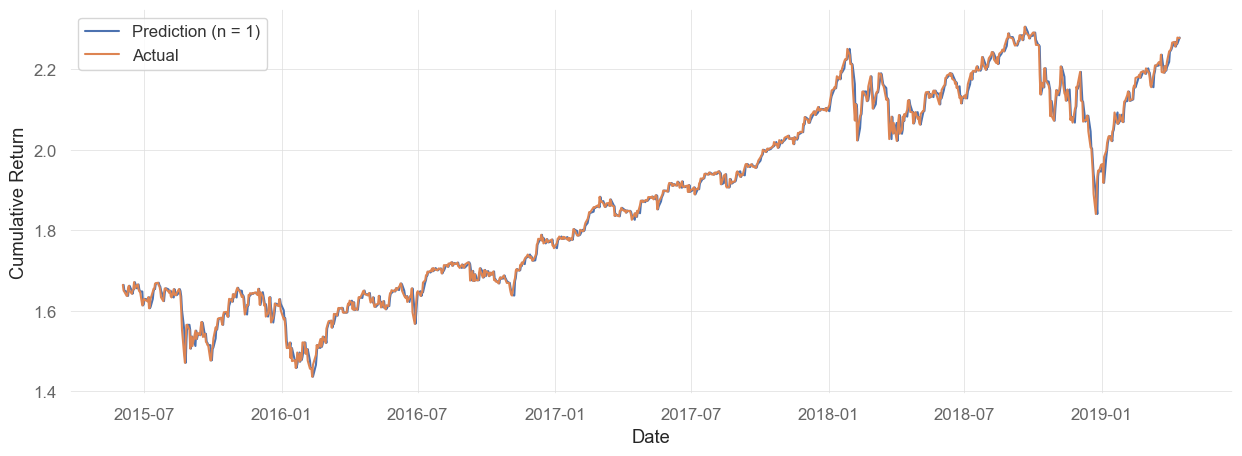

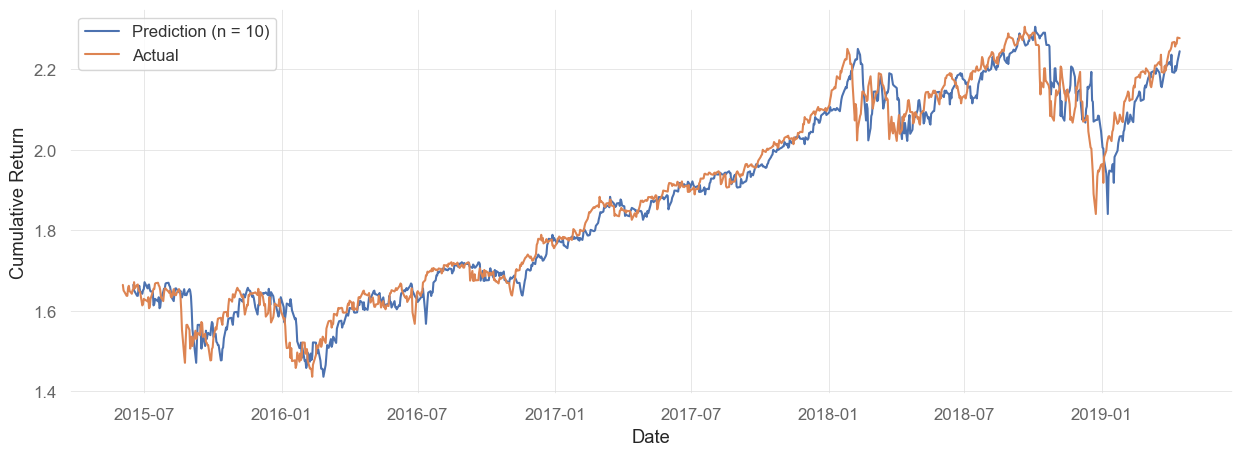

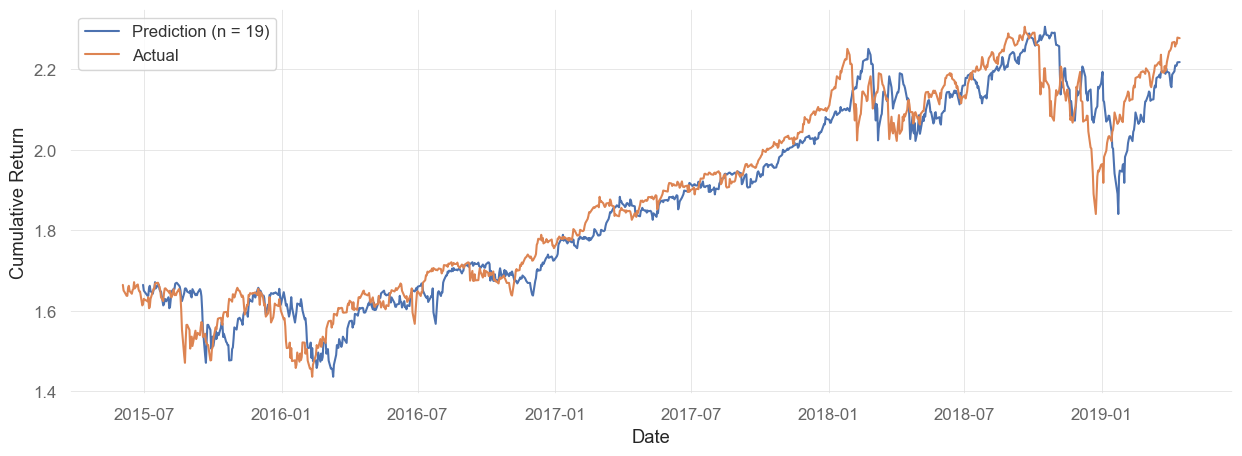

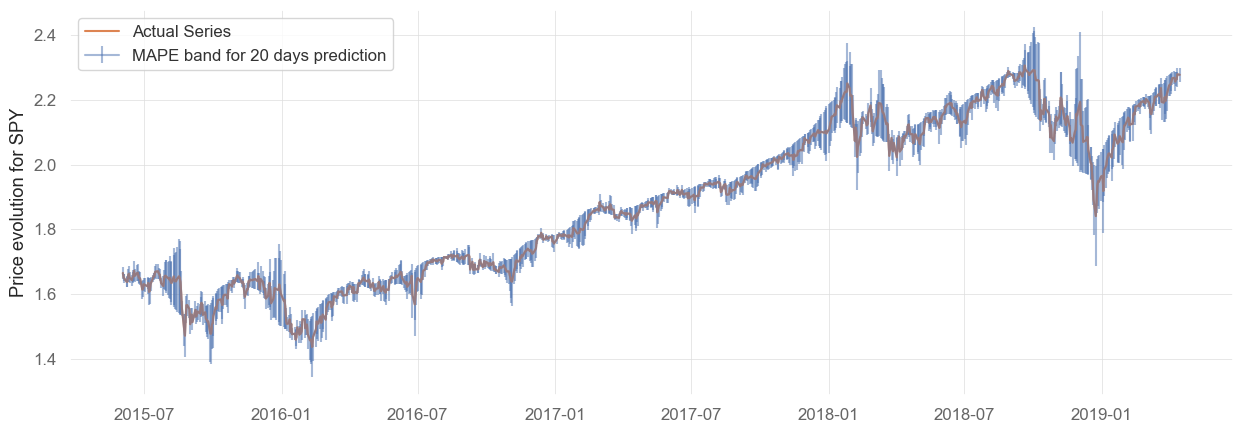

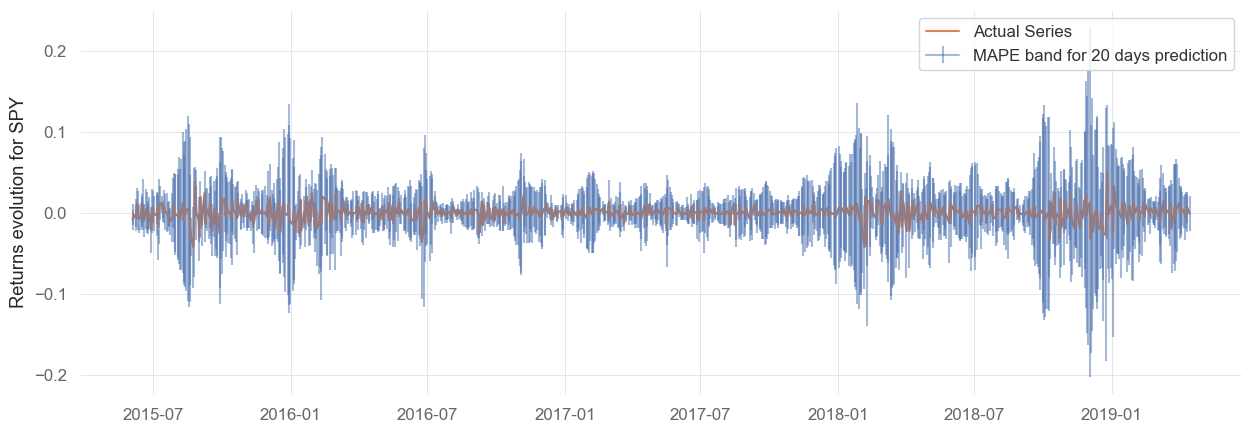

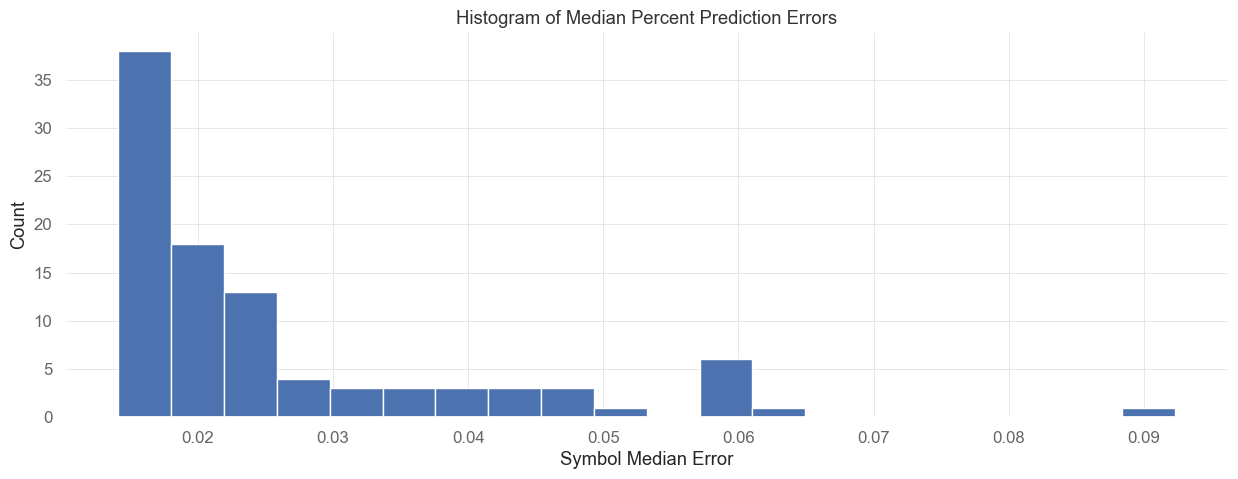

count    97.000000
mean      0.026057
std       0.014992
min       0.014118
25%       0.016209
50%       0.020370
75%       0.029749
max       0.092311
Name: 50%, dtype: float64
Median of Median Errors    0.020370
Mean of Median Errors      0.026057
Mean of Mean Errors        0.032150
dtype: float64


In [11]:
summary_analysis(
    df=df_train,
    n_predict=w_size,
    predictions=predictions_last_value,
    actuals=actuals,
    index_start=i_predict_min,
    index_end=i_predict_max,
    symbol="SPY",
)

So on average, the simple moving average baseline does not seem to do better than just assuming freezing the price series value and use it as prediction. In the plots above we see that the moving average extrapolation based strategy has the issue of easily exploding away from the mean behavior, whereas the frozen price baseline has a sistematic delay (which, however, deviates less from the true series).  